In [1]:
import sys
import pickle
import glob
import shutil
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.models import vgg19
from torch import nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchsummary import summary
from torchinfo import summary
# from torchvision.models.vgg.V import VGG19_Weights
import warnings 
import os
warnings.filterwarnings("ignore")
import cv2
from utils import *

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
base_path = os.path.dirname(os.path.abspath('__file__'))
data_path = os.path.join(base_path, 'data','data_for_vgg_augmented')
train_path = os.path.join(data_path,'train')
test_path = os.path.join(data_path,'test')

In [3]:
with open('classes.txt', 'rb') as f:
    classes = pickle.load(f)

## build the model

In [4]:
num_of_classes = len(classes)
img_width, img_height = 224, 224
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache()
device

'cuda'

In [13]:
# model_vgg19 = vgg19(pretrained=True)
# model_vgg19.classifier[6] = nn.Linear(in_features=4096, out_features = num_of_classes, bias=True)

In [14]:
# for param in model_vgg19.features.parameters():
#     param.requires_grad = False

In [16]:
# summary(model_vgg19, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
#         verbose=0,
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )

In [8]:
def train_the_model():
    print('start defineing the model')
    # define the model
    model_vgg19 = vgg19(pretrained=True)
    model_vgg19.classifier[6] = nn.Linear(in_features=4096, out_features = num_of_classes, bias=True)
    
    # freeze feature layers
    for param in model_vgg19.features.parameters():
        param.requires_grad = False
    
    # Define the transformation for the input images
    transform = transforms.Compose([
        transforms.Resize((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load the dataset
    train_data_dir = os.path.join(data_path, 'train')
    validation_data_dir = os.path.join(data_path, 'test')

    train_dataset = ImageFolder(train_data_dir, transform=transform)
    validation_dataset = ImageFolder(validation_data_dir, transform=transform)

    # Create data loaders
    batch_size = 4
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Move the model to the device
    model_vgg19 = model_vgg19.to(device)

    # Define the loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_vgg19.parameters(), lr=0.001)

    # Train the model
    epochs = 10

    # document statistics
    train_accuracy_per_epoch = []
    train_cross_entropy_per_epoch = []
    test_accuracy_per_epoch = []
    test_cross_entropy_per_epoch = []

    for epoch in range(epochs):
        train_loss, train_acc = 0, 0

        model_vgg19.train()
        for inputs, y_true in train_loader:
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            y_pred = model_vgg19(inputs)

            loss = loss_fn(y_pred, y_true)
            train_loss += loss.item() 

            optimizer.zero_grad() 

            loss.backward()

            optimizer.step()


            # Calculate and accumulate accuracy metric across all batches
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == y_true).sum().item()/len(y_pred)


         # Adjust metrics to get average loss and accuracy per batch 
        train_loss = train_loss / len(train_loader)
        train_acc = train_acc / len(train_loader)

        print(f"Epoch {epoch + 1}/{epochs} - Loss: {train_loss:.4f} - Accuracy: {train_acc:.4f}")

        train_cross_entropy_per_epoch.append(train_loss)
        train_accuracy_per_epoch.append(train_acc)


        model_vgg19.eval()
        with torch.no_grad():
            test_loss, test_acc = 0, 0

            for inputs, y_true in validation_loader:
                inputs = inputs.to(device)
                y_true = y_true.to(device)

                y_pred = model_vgg19(inputs)

                loss = loss_fn(y_pred, y_true)
                test_loss += loss.item()


                y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
                test_acc += (y_pred_class == y_true).sum().item()/len(y_pred)

            # Adjust metrics to get average loss and accuracy per batch 
            test_loss = test_loss / len(validation_loader)
            test_acc = test_acc / len(validation_loader)

            print(f"Validation Loss: {test_loss:.4f} - Validation Accuracy: {test_acc:.4f}")

            test_cross_entropy_per_epoch.append(test_loss)
            test_accuracy_per_epoch.append(test_acc)

    # Save the trained model
#     torch.save(model_vgg19.state_dict(), 'vgg19_101_classes_model.pth')
    
    return train_cross_entropy_per_epoch, train_accuracy_per_epoch, test_cross_entropy_per_epoch, test_accuracy_per_epoch



In [9]:
# train_accuracy_1, test_accuracy_1

In [10]:
delete_all_augmented(train_path)
reset_data(train_path, test_path)
split_data(train_path, test_path)
augment_images(train _path)
train_cross_entropy_1, train_accuracy_1, test_cross_entropy_1, test_accuracy_1 = train_the_model()
delete_all_augmented(train_path)
reset_data(train_path, test_path)
split_data(train_path, test_path)
augment_images(train_path)
train_cross_entropy_2, train_accuracy_2, test_cross_entropy_2, test_accuracy_2 = train_the_model()

start defineing the model
Epoch 1/10 - Loss: 4.8026 - Accuracy: 0.0974
Validation Loss: 3.5832 - Validation Accuracy: 0.2017
Epoch 2/10 - Loss: 4.3664 - Accuracy: 0.1244
Validation Loss: 3.9695 - Validation Accuracy: 0.1296
Epoch 3/10 - Loss: 4.3209 - Accuracy: 0.1150
Validation Loss: 3.9651 - Validation Accuracy: 0.1409
Epoch 4/10 - Loss: 4.3556 - Accuracy: 0.1116
Validation Loss: 4.0962 - Validation Accuracy: 0.1270
Epoch 5/10 - Loss: 4.3654 - Accuracy: 0.1061
Validation Loss: 4.1578 - Validation Accuracy: 0.1094
Epoch 6/10 - Loss: 4.3484 - Accuracy: 0.1079
Validation Loss: 4.0925 - Validation Accuracy: 0.1270
Epoch 7/10 - Loss: 4.3482 - Accuracy: 0.1114
Validation Loss: 4.0967 - Validation Accuracy: 0.1233
Epoch 8/10 - Loss: 4.2754 - Accuracy: 0.1117
Validation Loss: 4.0921 - Validation Accuracy: 0.1228
Epoch 9/10 - Loss: 4.3531 - Accuracy: 0.1113
Validation Loss: 4.1115 - Validation Accuracy: 0.1208
Epoch 10/10 - Loss: 4.3506 - Accuracy: 0.1081
Validation Loss: 4.0617 - Validation 

In [11]:
save_path = os.path.join(base_path, 'vgg ypred ytrue')
# np.savetxt(os.path.join(save_path,'train_accuracy_1.txt'), train_accuracy_1)
# np.savetxt(os.path.join(save_path,'test_accuracy_1.txt'), test_accuracy_1)
# np.savetxt(os.path.join(save_path,'train_cross_entropy_1.txt'), train_cross_entropy_1)
# np.savetxt(os.path.join(save_path,'test_cross_entropy_1.txt'), test_cross_entropy_1)

np.savetxt(os.path.join(save_path,'train_accuracy_2.txt'), train_accuracy_2)
np.savetxt(os.path.join(save_path,'test_accuracy_2.txt'), test_accuracy_2)
np.savetxt(os.path.join(save_path,'train_cross_entropy_2.txt'), train_cross_entropy_2)
np.savetxt(os.path.join(save_path,'test_cross_entropy_2.txt'), test_cross_entropy_2)

In [9]:
save_path = os.path.join(base_path, 'vgg ypred ytrue')
train_accuracy_1 = np.loadtxt(os.path.join(save_path,'train_accuracy_1.txt'))
test_accuracy_1 = np.loadtxt(os.path.join(save_path,'test_accuracy_1.txt'))
train_cross_entropy_1 = np.loadtxt(os.path.join(save_path,'train_cross_entropy_1.txt'))
test_cross_entropy_1 = np.loadtxt(os.path.join(save_path,'test_cross_entropy_1.txt'))

train_accuracy_2 = np.loadtxt(os.path.join(save_path,'train_accuracy_2.txt'))
test_accuracy_2 = np.loadtxt(os.path.join(save_path,'test_accuracy_2.txt'))
train_cross_entropy_2 = np.loadtxt(os.path.join(save_path,'train_cross_entropy_2.txt'))
test_cross_entropy_2 = np.loadtxt(os.path.join(save_path,'test_cross_entropy_2.txt'))

In [10]:
train_cross_entropy_2, train_accuracy_2, test_cross_entropy_2, test_accuracy_2

(array([4.80259767, 4.36642287, 4.32090874, 4.35564447, 4.36542696,
        4.34836734, 4.34819845, 4.27543524, 4.35310319, 4.35061835]),
 array([0.09741211, 0.12444196, 0.11495536, 0.11157227, 0.10606166,
        0.10794503, 0.111363  , 0.1116769 , 0.11129325, 0.10811942]),
 array([3.58315842, 3.96954712, 3.9651203 , 4.09621152, 4.1577687 ,
        4.0925046 , 4.09671057, 4.09210476, 4.1114972 , 4.0616556 ]),
 array([0.20166016, 0.12963867, 0.14086914, 0.12695312, 0.109375  ,
        0.12695312, 0.12329102, 0.12280273, 0.12084961, 0.13037109]))

In [17]:
train_accuracy_average = (train_accuracy_1 + train_accuracy_2) /2
test_accuracy_average = (test_accuracy_1 + test_accuracy_2) /2

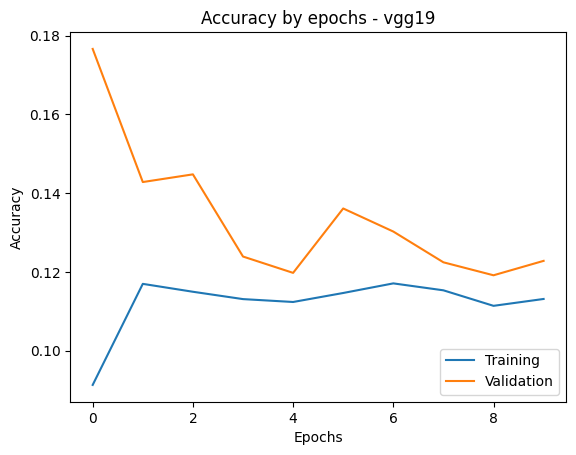

In [19]:
plt.plot(range(len(train_accuracy_average)), train_accuracy_average,
         label='Training')
plt.plot(range(len(test_accuracy_average)), test_accuracy_average,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.title('Accuracy by epochs - vgg19')
plt.show()

In [20]:
test_accuracy_average[-1]

0.122802734375

In [21]:
train_cross_entropy_average = (train_cross_entropy_1 + train_cross_entropy_2) /2
test_cross_entropy_average = (test_cross_entropy_1 + test_cross_entropy_2) /2

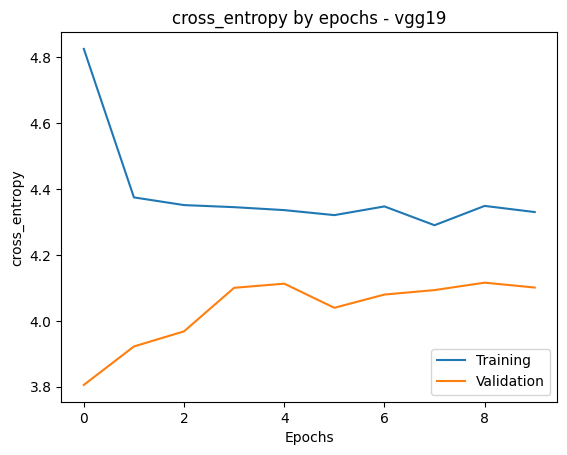

In [22]:
plt.plot(range(len(train_cross_entropy_average)), train_cross_entropy_average,
         label='Training')
plt.plot(range(len(test_cross_entropy_average)), test_cross_entropy_average,
         label='Validation')
plt.ylabel('cross_entropy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.title('cross_entropy by epochs - vgg19')
plt.show()